In [1]:
# Cell 1: Imports and Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
from collections import Counter
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
import gensim.downloader as api
import networkx as nx
from matplotlib_venn import venn2
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from textblob import TextBlob


# Set display options and working directory
pd.set_option('display.max_columns', None)
os.chdir(r'C:\Users\Ryo\OneDrive\Desktop\Master Thesis\master_thesis\study1')

# Load data
gpt4o_result_justification = pd.read_excel('transformed/gpt4o_result_justification.xlsx')
claude_result_justification = pd.read_excel('transformed/claude_result_justification.xlsx')
gpt35_result_justification = pd.read_excel('transformed/gpt35_result_justification.xlsx')

# Rename columns for consistency
def rename_FT(df):
    return df.rename(columns={
        'Justification for 1st choice (TF)': 'Justification for 1st choice (FT)',
        'Justification for 1st choice (PJ)': 'Justification for 1st choice (JP)'
    })

gpt4o_result_justification = rename_FT(gpt4o_result_justification)
claude_result_justification = rename_FT(claude_result_justification)
gpt35_result_justification = rename_FT(gpt35_result_justification)

# Define MBTI traits
all_traits = ['EI', 'NS', 'FT', 'JP']

# Function to select dataframe
def select_df(df_name):
    if df_name == 'gpt4o':
        return gpt4o_result_justification
    elif df_name == 'claude':
        return claude_result_justification
    elif df_name == 'gpt35':
        return gpt35_result_justification
    else:
        raise ValueError("Invalid dataframe name. Choose 'gpt4o', 'claude', or 'gpt35'.")

In [2]:
# Accuracy Analysis
def accuracy_analysis(df_name, traits=all_traits):
    """
    Analyze prediction accuracy for specified MBTI traits.
    
    This function helps understand which traits the LLM predicts more accurately,
    potentially revealing areas where the model excels or struggles.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    
    Returns:
    dict: Accuracy scores for each trait.
    """
    df = select_df(df_name)
    accuracies = {trait: df[f'is_matched({trait})'].mean() for trait in traits}
    
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title(f"Prediction Accuracy by MBTI Trait ({df_name})")
    plt.ylabel("Accuracy")
    plt.show()
    
    return accuracies

In [3]:
# Text Length vs. Accuracy Analysis
def text_length_analysis(df_name, traits=all_traits):
    """
    Analyze the relationship between text length and prediction accuracy.
    
    This function helps identify if the length of input text affects the LLM's
    ability to accurately predict MBTI traits, potentially revealing biases
    related to text length.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)
    df['text_length'] = df['posts_filtered'].str.len()

    plt.figure(figsize=(12, 8))
    data = []

    for trait in traits:
        correct = df[df[f'is_matched({trait})'] == True]
        incorrect = df[df[f'is_matched({trait})'] == False]
        
        data.extend([
            {'Trait': trait, 'Accuracy': 'Correct', 'Text Length': length} for length in correct['text_length']
        ])
        data.extend([
            {'Trait': trait, 'Accuracy': 'Incorrect', 'Text Length': length} for length in incorrect['text_length']
        ])

    plot_df = pd.DataFrame(data)

    sns.violinplot(x='Trait', y='Text Length', hue='Accuracy', data=plot_df, split=True)
    plt.title(f'Text Length Distribution by MBTI Trait and Prediction Accuracy ({df_name})')
    plt.show()

In [4]:


# Accuracy vs Sentiment Analysis
def accuracy_sentiment_analysis(df_name, traits=all_traits):
    """
    Analyze the relationship between prediction accuracy and sentiment of justifications.
    
    This function explores whether there's a correlation between the sentiment of
    the LLM's justifications and its prediction accuracy, potentially revealing
    biases in the model's confidence or language use.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)
    
    def get_sentiment(text):
        return TextBlob(text).sentiment.polarity

    plt.figure(figsize=(12, 8))
    data = []

    for trait in traits:
        df[f'sentiment_{trait}'] = df[f'Justification for 1st choice ({trait})'].apply(get_sentiment)
        
        correct = df[df[f'is_matched({trait})'] == True]
        incorrect = df[df[f'is_matched({trait})'] == False]
        
        data.extend([
            {'Trait': trait, 'Accuracy': 'Correct', 'Sentiment': sentiment} 
            for sentiment in correct[f'sentiment_{trait}']
        ])
        data.extend([
            {'Trait': trait, 'Accuracy': 'Incorrect', 'Sentiment': sentiment} 
            for sentiment in incorrect[f'sentiment_{trait}']
        ])

    plot_df = pd.DataFrame(data)

    sns.violinplot(x='Trait', y='Sentiment', hue='Accuracy', data=plot_df, split=True)
    plt.title(f'Sentiment Distribution by MBTI Trait and Prediction Accuracy ({df_name})')
    plt.show()

In [5]:
# Cell: LSA Justification Analysis
def lsa_justification_analysis(df_name, traits=all_traits):
    """
    Perform Latent Semantic Analysis on justifications and visualize results.
    
    This function applies LSA to the justifications provided by the LLM, allowing
    for the exploration of latent themes in correct vs incorrect predictions.
    It can reveal patterns in the model's reasoning that may not be immediately
    apparent from the raw text.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)

    for trait in traits:
        justifications = df[f'Justification for 1st choice ({trait})']
        
        vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        tfidf_matrix = vectorizer.fit_transform(justifications)
        
        lsa = TruncatedSVD(n_components=2, random_state=42)
        lsa_result = lsa.fit_transform(tfidf_matrix)
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(lsa_result[:, 0], lsa_result[:, 1], 
                              c=df[f'is_matched({trait})'], cmap='coolwarm', alpha=0.6)
        plt.colorbar(scatter)
        plt.title(f'LSA of Justifications for {trait} ({df_name})')
        plt.xlabel('First LSA component')
        plt.ylabel('Second LSA component')
        plt.show()

        print(f"Top words for first component of {trait}:")
        top_words = sorted(zip(vectorizer.get_feature_names_out(), lsa.components_[0]), key=lambda x: abs(x[1]), reverse=True)[:10]
        for word, score in top_words:
            print(f"{word}: {score}")
        
        print(f"\nTop words for second component of {trait}:")
        top_words = sorted(zip(vectorizer.get_feature_names_out(), lsa.components_[1]), key=lambda x: abs(x[1]), reverse=True)[:10]
        for word, score in top_words:
            print(f"{word}: {score}")
        print("\n")

In [6]:
# Keyword Analysis
def keyword_analysis(df_name, traits=all_traits):
    """
    Analyze top keywords in correct and incorrect predictions.
    
    This function helps identify specific words or themes that the LLM associates
    with correct or incorrect predictions for each trait, potentially revealing
    biases or patterns in the model's decision-making process.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)
    stop_words = set(stopwords.words('english'))

    def get_top_keywords(text, n=30):
        words = text.lower().split()
        words = [word for word in words if word not in stop_words]
        return Counter(words).most_common(n)

    def plot_top_keywords(correct_keywords, incorrect_keywords, trait, n=10):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        correct_words, correct_counts = zip(*correct_keywords[:n])
        incorrect_words, incorrect_counts = zip(*incorrect_keywords[:n])
        
        ax1.barh(correct_words, correct_counts)
        ax1.set_title(f'Top {n} Keywords for Correct {trait} Predictions ({df_name})')
        ax1.set_xlabel('Count')
        
        ax2.barh(incorrect_words, incorrect_counts)
        ax2.set_title(f'Top {n} Keywords for Incorrect {trait} Predictions ({df_name})')
        ax2.set_xlabel('Count')
        
        plt.tight_layout()
        plt.show()

    for trait in traits:
        correct_text = ' '.join(df[df[f'is_matched({trait})'] == True]['posts_filtered'])
        incorrect_text = ' '.join(df[df[f'is_matched({trait})'] == False]['posts_filtered'])
        
        correct_keywords = get_top_keywords(correct_text)
        incorrect_keywords = get_top_keywords(incorrect_text)
        
        plot_top_keywords(correct_keywords, incorrect_keywords, trait)

In [7]:
# Cell 5: Topic Modeling (LDA)
def topic_modeling(df_name, traits=all_traits):
    """
    Perform topic modeling on the justifications for each trait prediction.
    
    This function helps uncover latent themes in the LLM's justifications,
    providing insight into the model's reasoning process and potential biases
    in its understanding of MBTI traits.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)

    def preprocess(text):
        return [word for word in gensim.utils.simple_preprocess(text) if word not in STOPWORDS]

    for trait in traits:
        documents = df[f'Justification for 1st choice ({trait})'].apply(preprocess)
        dictionary = corpora.Dictionary(documents)
        corpus = [dictionary.doc2bow(text) for text in documents]

        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5)

        vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
        pyLDAvis.save_html(vis, f'lda_visualization_{df_name}_{trait}.html')

        print(f"LDA visualization for {trait} saved as 'lda_visualization_{df_name}_{trait}.html'.")

        for idx, topic in lda_model.print_topics(-1):
            print(f"Topic: {idx}")
            words = [(word, round(prob, 4)) for word, prob in lda_model.show_topic(idx, topn=10)]
            print(words)
            print()

In [8]:
# Cell 6: N-gram Analysis
def ngram_analysis(df_name, traits=all_traits):
    """
    Analyze top n-grams in correct and incorrect predictions.
    
    This function helps identify common phrases or word combinations that the LLM
    associates with correct or incorrect predictions for each trait, potentially
    revealing more complex patterns in the model's decision-making process.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)

    def get_top_ngrams(text, n, top_k=10):
        tokens = gensim.utils.simple_preprocess(text)
        ng = ngrams(tokens, n)
        fdist = nltk.FreqDist(ng)
        return fdist.most_common(top_k)

    def plot_top_ngrams(correct_ngrams, incorrect_ngrams, n, trait):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        correct_phrases, correct_counts = zip(*correct_ngrams)
        incorrect_phrases, incorrect_counts = zip(*incorrect_ngrams)
        
        correct_phrases = [' '.join(phrase) for phrase in correct_phrases]
        incorrect_phrases = [' '.join(phrase) for phrase in incorrect_phrases]
        
        ax1.barh(correct_phrases, correct_counts)
        ax1.set_title(f'Top {len(correct_ngrams)} {n}-grams in Correct {trait} Predictions ({df_name})')
        ax1.set_xlabel('Count')
        
        ax2.barh(incorrect_phrases, incorrect_counts)
        ax2.set_title(f'Top {len(incorrect_ngrams)} {n}-grams in Incorrect {trait} Predictions ({df_name})')
        ax2.set_xlabel('Count')
        
        plt.tight_layout()
        plt.show()

    for trait in traits:
        correct_text = ' '.join(df[df[f'is_matched({trait})']][f'Justification for 1st choice ({trait})'])
        incorrect_text = ' '.join(df[~df[f'is_matched({trait})']][f'Justification for 1st choice ({trait})'])

        for n in [2, 3]:  # Bigrams and trigrams
            correct_ngrams = get_top_ngrams(correct_text, n)
            incorrect_ngrams = get_top_ngrams(incorrect_text, n)
            plot_top_ngrams(correct_ngrams, incorrect_ngrams, n, trait)


In [9]:
def word_embedding_analysis(df_name, traits=all_traits):
    """
    Analyze word embedding similarities for key terms related to each trait.
    
    This function helps explore the semantic relationships between key MBTI-related
    terms in the LLM's understanding, potentially revealing biases or misconceptions
    in the model's interpretation of MBTI concepts.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    word_vectors = api.load('glove-wiki-gigaword-100')

    def get_similar_words(word, n=10):
        return word_vectors.most_similar(word, topn=n)

    def plot_word_similarity(word, similar_words, trait):
        G = nx.Graph()
        G.add_node(word)
        for similar_word, similarity in similar_words:
            G.add_node(similar_word)
            G.add_edge(word, similar_word, weight=similarity)
        
        pos = nx.spring_layout(G)
        plt.figure(figsize=(10, 8))
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold')
        
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        plt.title(f"Words similar to '{word}' for {trait} ({df_name})")
        plt.axis('off')
        plt.show()

    traits_dict = {
        'EI': ['extraversion', 'introversion'],
        'NS': ['intuition', 'sensing'],
        'FT': ['feeling', 'thinking'],
        'JP': ['judging', 'perceiving']
    }

    for trait in traits:
        if trait in traits_dict:
            for word in traits_dict[trait]:
                try:
                    similar_words = get_similar_words(word)
                    plot_word_similarity(word, similar_words, trait)
                except KeyError:
                    print(f"Word '{word}' not found in the word embeddings. Skipping...")
        else:
            print(f"Trait '{trait}' not recognized. Skipping...")


In [10]:
def word_usage_comparison(df_name, traits=all_traits):
    """
    Compare word usage patterns between correct and incorrect predictions.
    
    This function helps identify differences in vocabulary and language patterns
    between correct and incorrect predictions, potentially revealing linguistic
    cues that the LLM associates with different MBTI traits.
    
    Args:
    df_name (str): Name of the dataset to analyze.
    traits (list): List of MBTI traits to analyze.
    """
    df = select_df(df_name)

    def get_top_words(text, n=20):
        words = text.lower().split()
        words = [word for word in words if word.isalnum()]
        return Counter(words).most_common(n)

    def compare_word_usage(correct_text, incorrect_text, n=20):
        correct_words = set(dict(get_top_words(correct_text, n)).keys())
        incorrect_words = set(dict(get_top_words(incorrect_text, n)).keys())
        
        words_more_common_in_correct = correct_words - incorrect_words
        words_more_common_in_incorrect = incorrect_words - correct_words
        common_words = correct_words & incorrect_words
        
        print("Words more common in correct predictions:")
        print(words_more_common_in_correct)
        print("\nWords more common in incorrect predictions:")
        print(words_more_common_in_incorrect)
        print("\nWords common to both:")
        print(common_words)
        
        return correct_words, incorrect_words, common_words

    def plot_word_usage_comparison(correct_words, incorrect_words, common_words, correct_text, incorrect_text, trait):
        plt.figure(figsize=(12, 6))
        venn2([set(correct_words), set(incorrect_words)], 
              set_labels=('Correct Predictions', 'Incorrect Predictions'))
        plt.title(f'Word Usage Comparison for {trait} ({df_name})')
        plt.show()
        
        common_word_counts_correct = [correct_text.count(word) for word in common_words]
        common_word_counts_incorrect = [incorrect_text.count(word) for word in common_words]
        
        fig, ax = plt.subplots(figsize=(14, 6))
        x = range(len(common_words))
        width = 0.35
        
        ax.bar([i - width/2 for i in x], common_word_counts_correct, width, label='Correct Predictions', color='g', alpha=0.6)
        ax.bar([i + width/2 for i in x], common_word_counts_incorrect, width, label='Incorrect Predictions', color='r', alpha=0.6)
        
        ax.set_ylabel('Frequency')
        ax.set_title(f'Frequency of Common Words in Correct vs Incorrect Predictions for {trait} ({df_name})')
        ax.set_xticks(x)
        ax.set_xticklabels(common_words, rotation=45, ha='right')
        ax.legend()
        
        plt.tight_layout()
        plt.show()

    for trait in traits:
        correct_text = ' '.join(df[df[f'is_matched({trait})']].apply(lambda row: row[f'Justification for 1st choice ({trait})'], axis=1))
        incorrect_text = ' '.join(df[~df[f'is_matched({trait})']].apply(lambda row: row[f'Justification for 1st choice ({trait})'], axis=1))
        correct_words, incorrect_words, common_words = compare_word_usage(correct_text, incorrect_text)
        plot_word_usage_comparison(correct_words, incorrect_words, common_words, correct_text, incorrect_text, trait)

In [16]:
# Cell 9: To run analyses for specific traits and datasets:
def run(models='gpt4o', traits=['NS', 'JP']):
    analysis_functions = [
        accuracy_analysis,
        text_length_analysis,
        accuracy_sentiment_analysis, 
        lsa_justification_analysis,
        keyword_analysis,
        topic_modeling,
        ngram_analysis,
        word_embedding_analysis,
        word_usage_comparison
    ]

    def run_analyses(df_name):
        print(f"Running analyses for {df_name}")
        for func in analysis_functions:
            print(f"\n{func.__name__}")
            func(df_name, traits=traits)

    if models == 'all':
        for df_name in ['gpt4o', 'claude', 'gpt35']:
            run_analyses(df_name)
    else:
        run_analyses(models)

Running analyses for gpt4o

accuracy_analysis


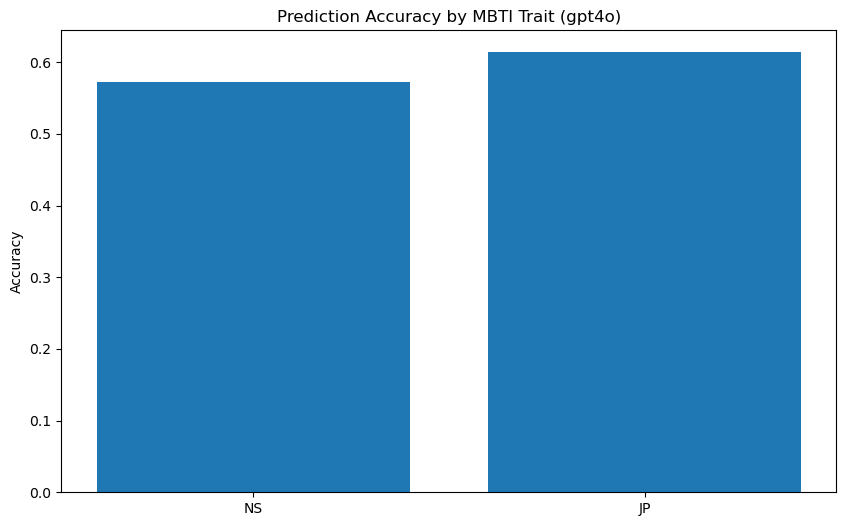


text_length_analysis


c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead


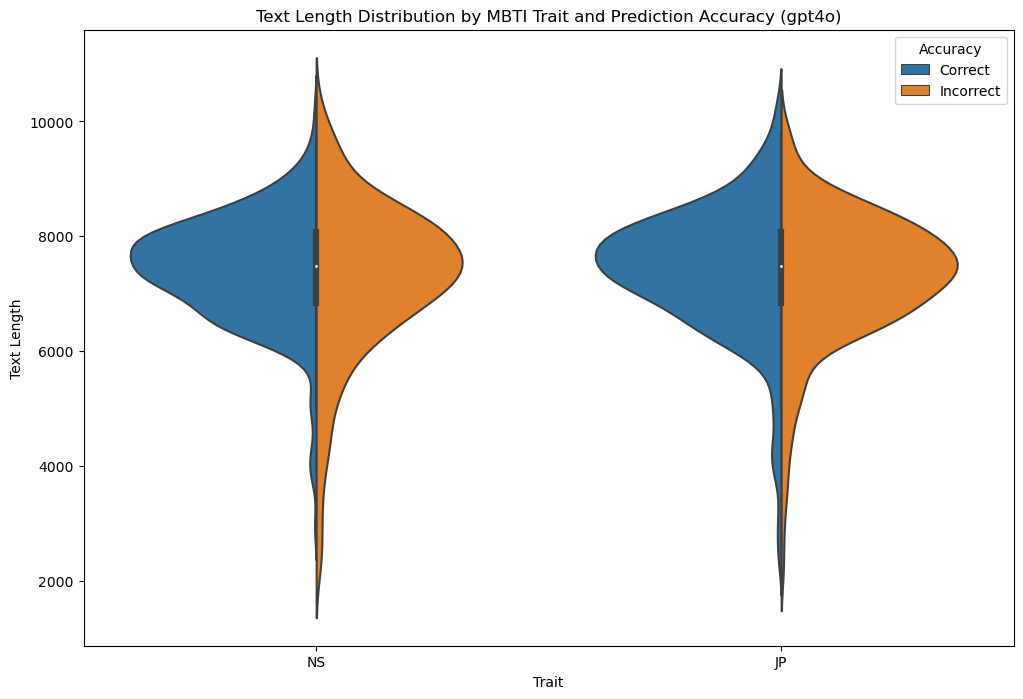


accuracy_sentiment_analysis


c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead


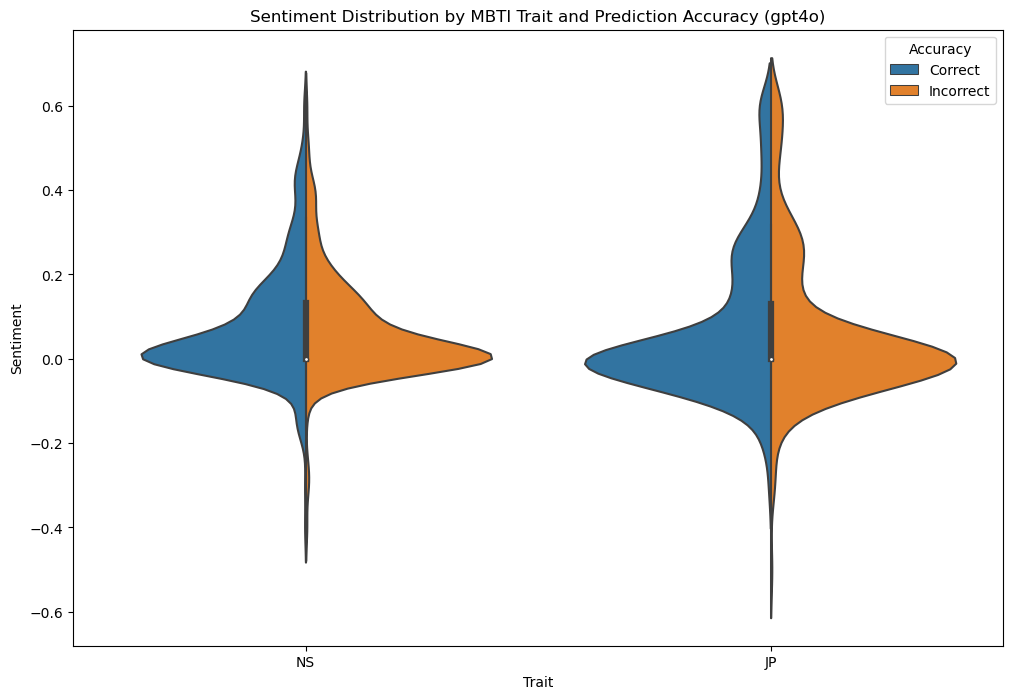


lsa_justification_analysis


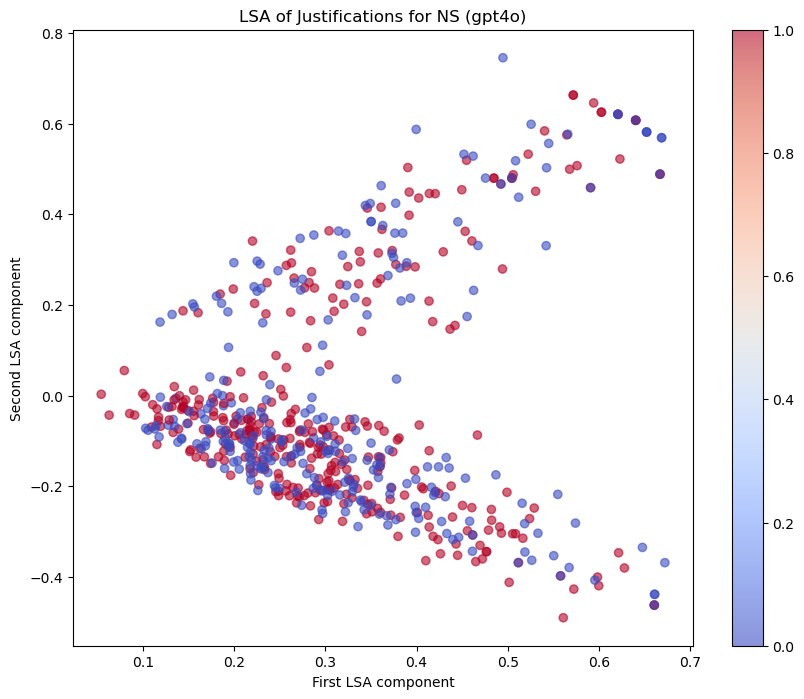

Top words for first component of NS:
intuition: 0.3098491900528437
abstract: 0.29598463057430396
preference: 0.2891194421392454
ideas: 0.2448379623925274
shows: 0.23632301582062396
emotional: 0.23151745293633655
emphasizes: 0.2314175791020843
depth: 0.2311476886295454
exploring: 0.22748539395834066
indicating: 0.21907102360872416

Top words for second component of NS:
depth: 0.3989570783715709
emotional: 0.3930991148158036
emphasizes: 0.38945875143219005
expressions: 0.3573714959169342
shows: -0.2816362840649415
exploring: -0.2726122588618524
ideas: -0.25006591684169
concepts: -0.16419603395659388
theoretical: -0.15623517490204078
expression: 0.13548800524525526




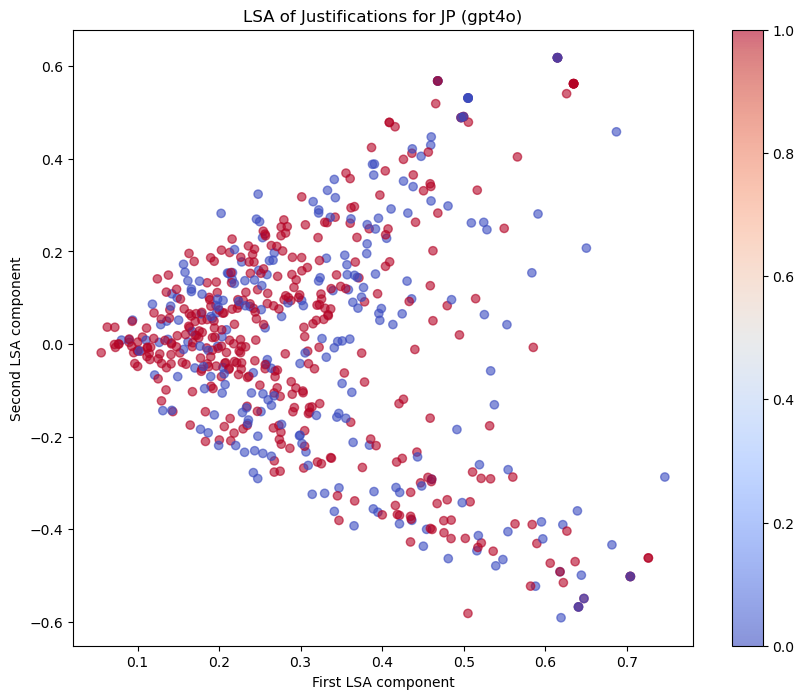

Top words for first component of JP:
perceiving: 0.32684799566658373
flexibility: 0.27610152474328353
characteristic: 0.27378078189422483
spontaneity: 0.2697793136708209
demonstrates: 0.2687829280929465
approach: 0.2671413068470663
open: 0.26496751189244594
ended: 0.2544654164295581
shows: 0.238169082310218
contemplative: 0.23544831647136935

Top words for second component of JP:
spontaneity: 0.3781808155710481
demonstrates: 0.36653931375800497
contemplative: -0.3488732434597099
flexibility: 0.34012843764575407
ended: -0.29673025149799703
shows: -0.2874720970622198
life: -0.25731712043079025
open: -0.24864277205984073
approach: -0.2213367388182427
characteristic: 0.18494930467398066



keyword_analysis


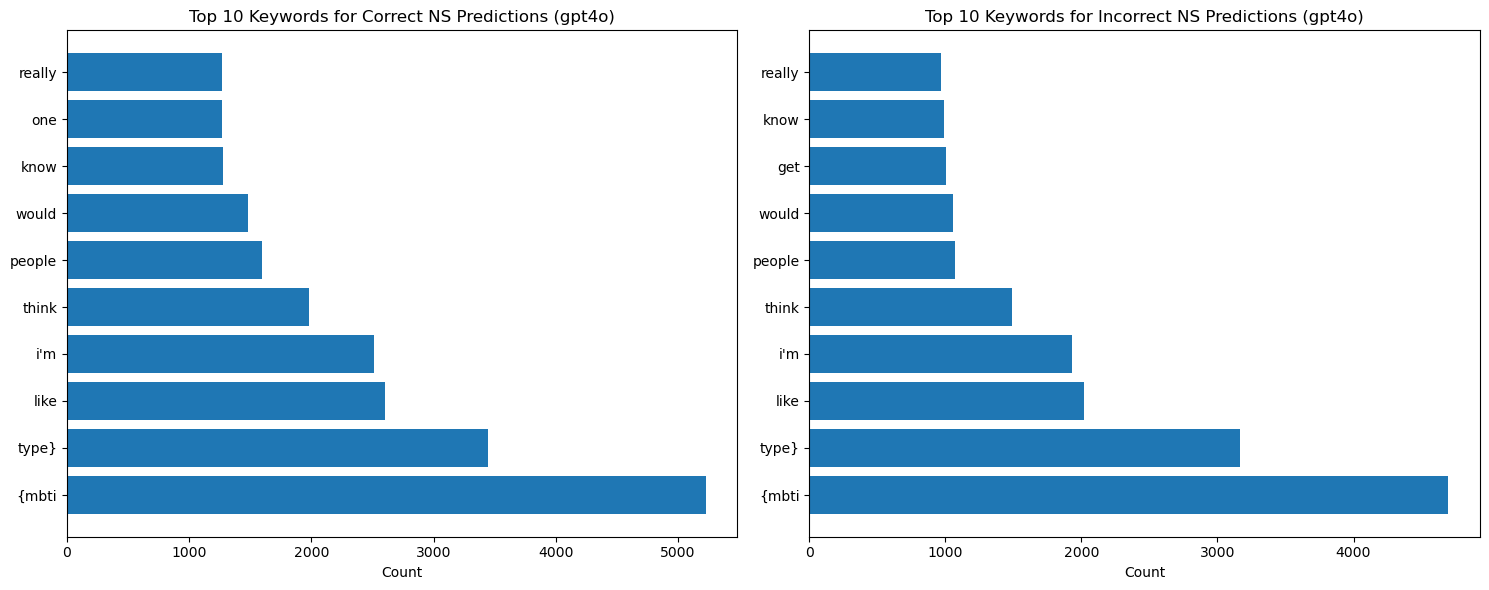

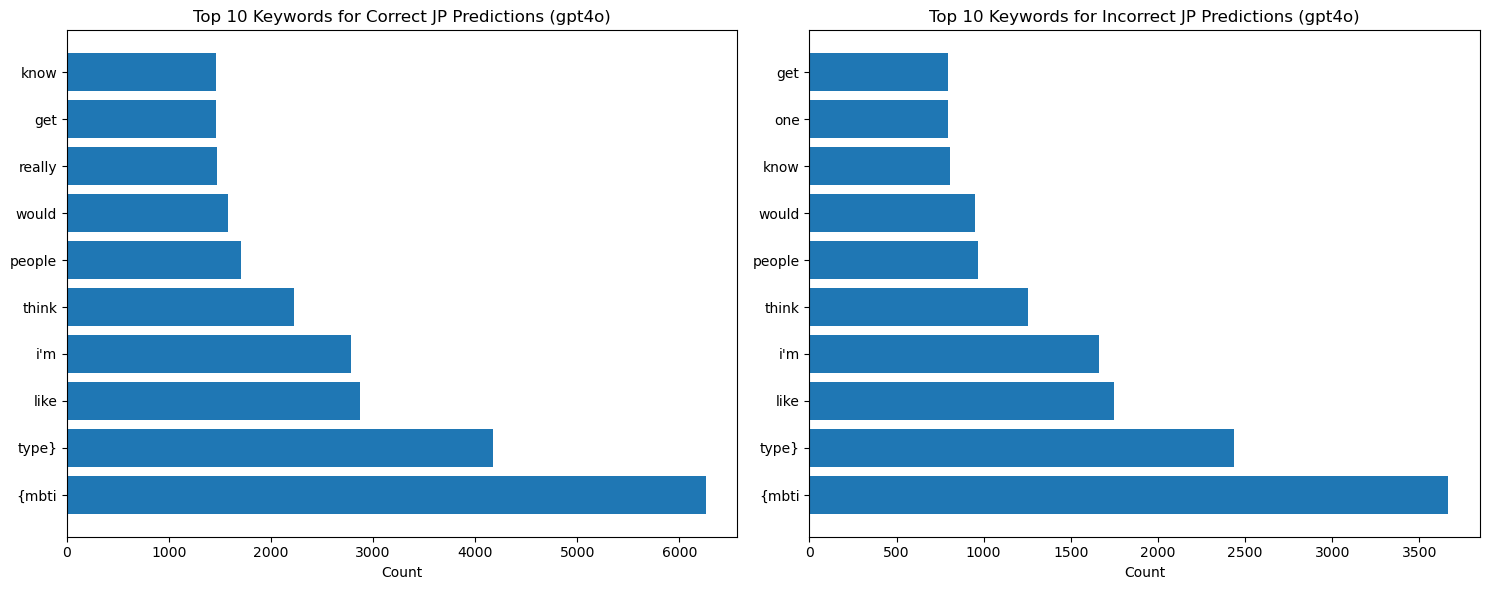


topic_modeling
LDA visualization for NS saved as 'lda_visualization_gpt4o_NS.html'.
Topic: 0
[('abstract', 0.0396), ('focus', 0.0305), ('sensing', 0.0235), ('concepts', 0.0185), ('concrete', 0.0175), ('indicating', 0.0175), ('shows', 0.0169), ('possibilities', 0.0155), ('intuition', 0.0154), ('details', 0.0152)]

Topic: 1
[('preference', 0.0637), ('abstract', 0.061), ('intuition', 0.0538), ('shows', 0.0399), ('indicating', 0.0384), ('ideas', 0.0352), ('exploring', 0.0257), ('strong', 0.0251), ('thinking', 0.0223), ('concepts', 0.0213)]

Topic: 2
[('abstract', 0.0748), ('intuition', 0.0544), ('preference', 0.0432), ('ideas', 0.0401), ('shows', 0.0352), ('emotional', 0.034), ('emphasizes', 0.0334), ('depth', 0.032), ('exploring', 0.0286), ('expressions', 0.0237)]

Topic: 3
[('abstract', 0.0798), ('preference', 0.0624), ('ideas', 0.0442), ('intuition', 0.0441), ('shows', 0.032), ('emphasizes', 0.0268), ('emotional', 0.0265), ('exploring', 0.0255), ('depth', 0.0246), ('details', 0.0242)]


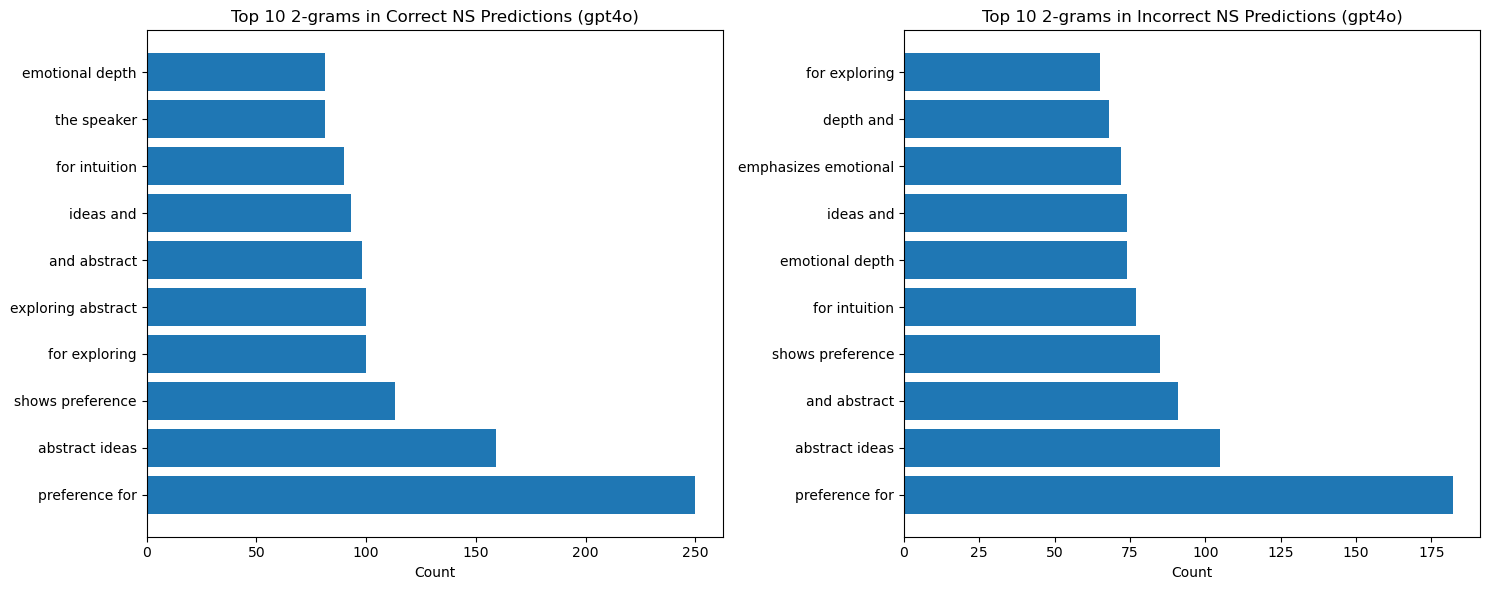

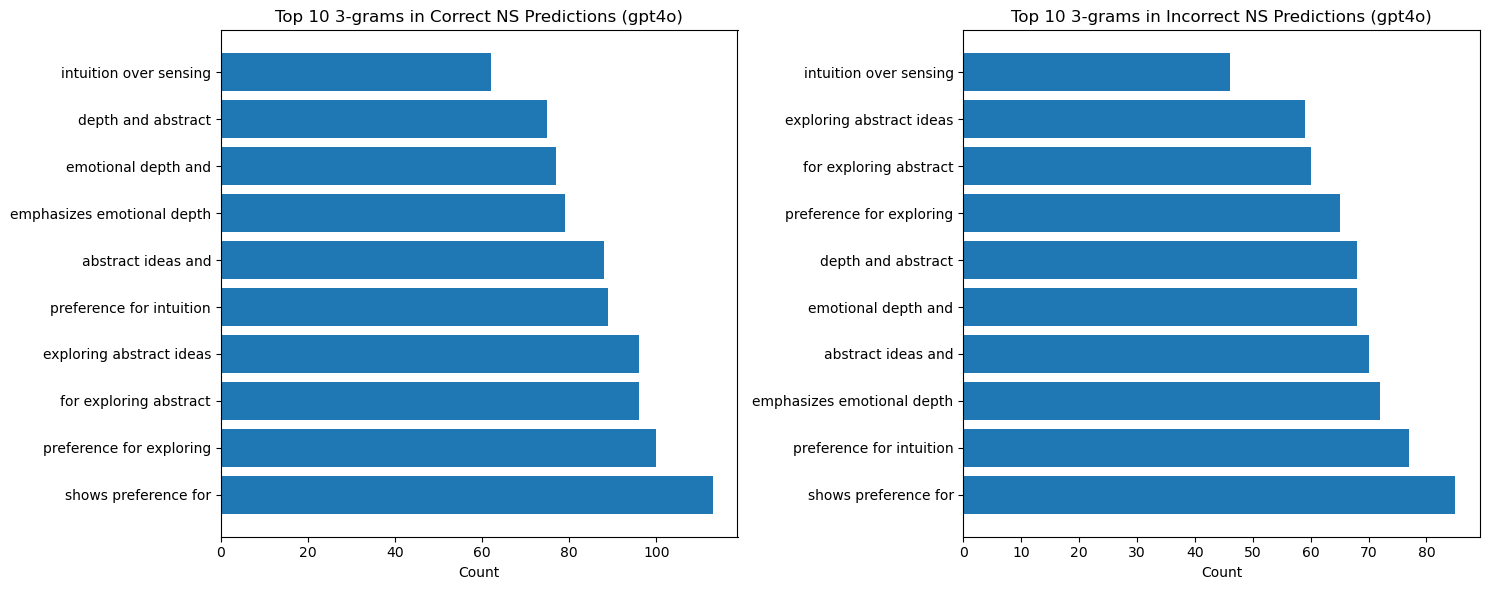

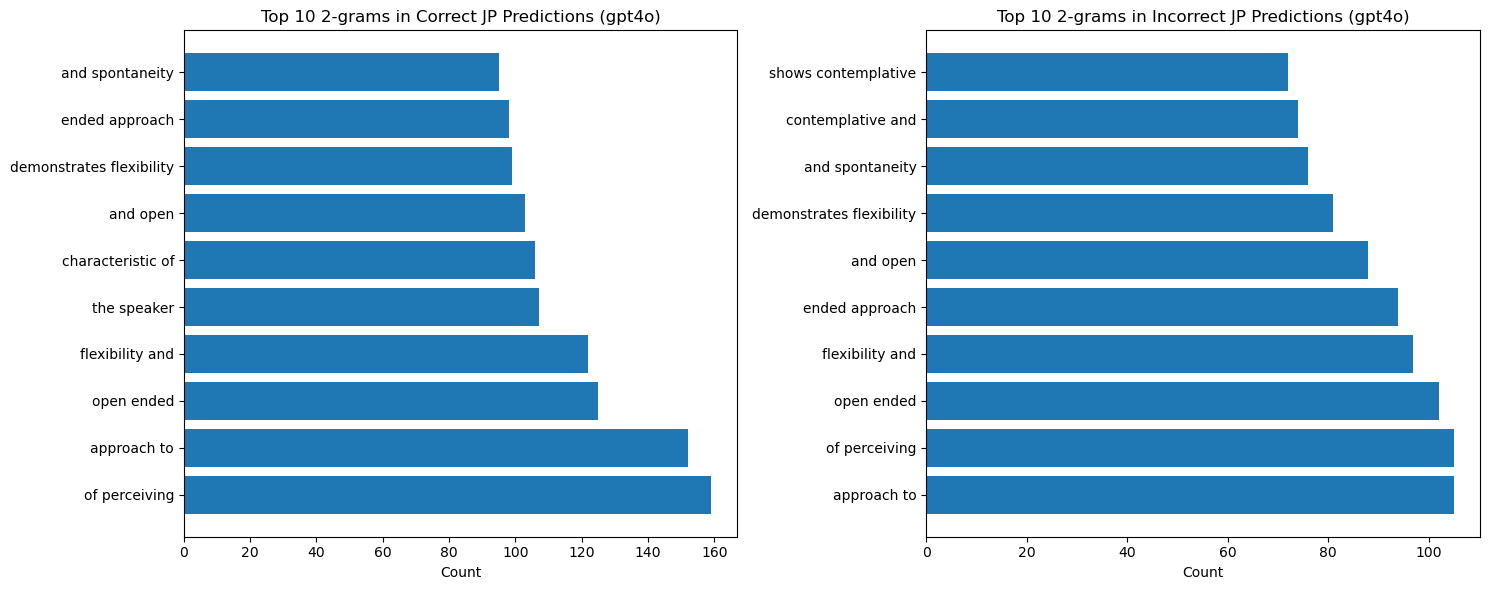

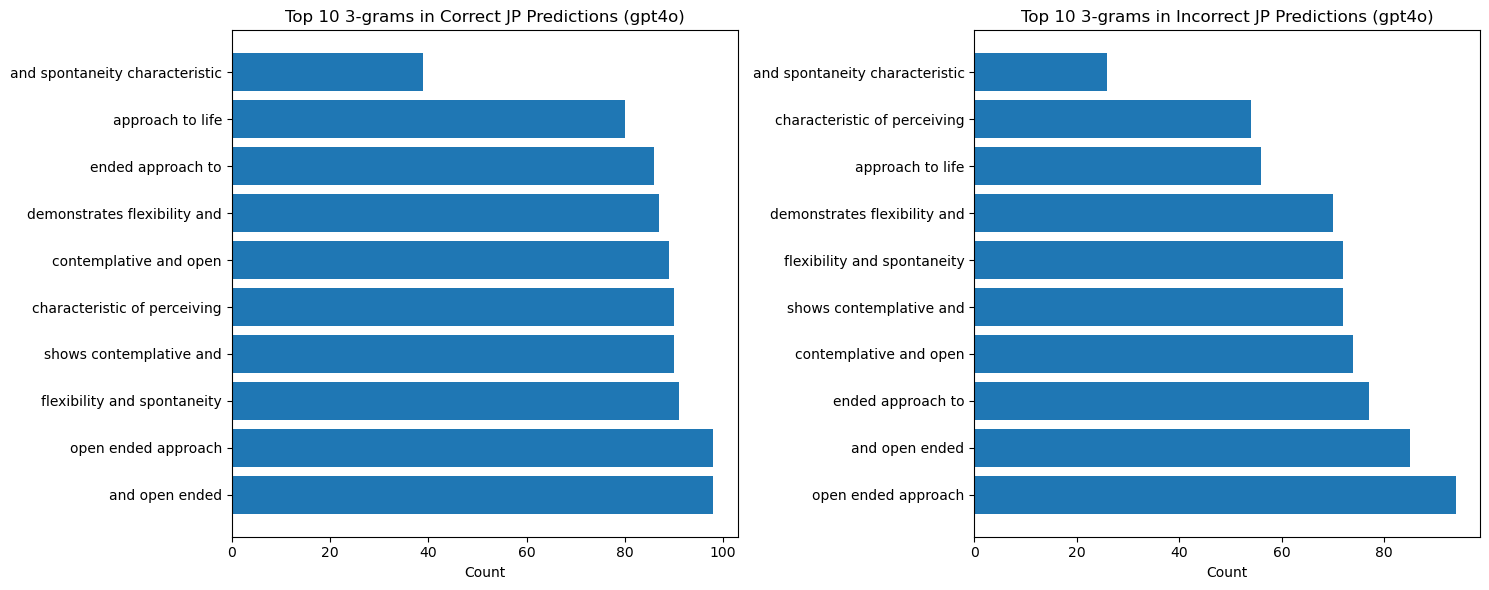


word_embedding_analysis


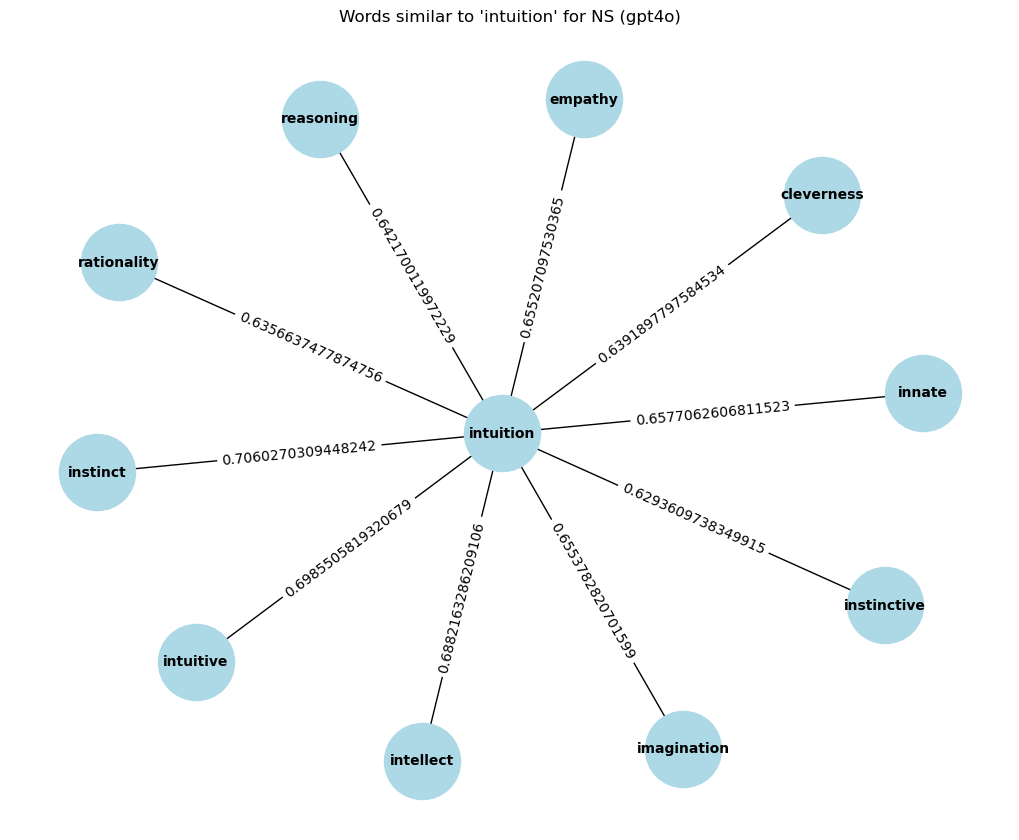

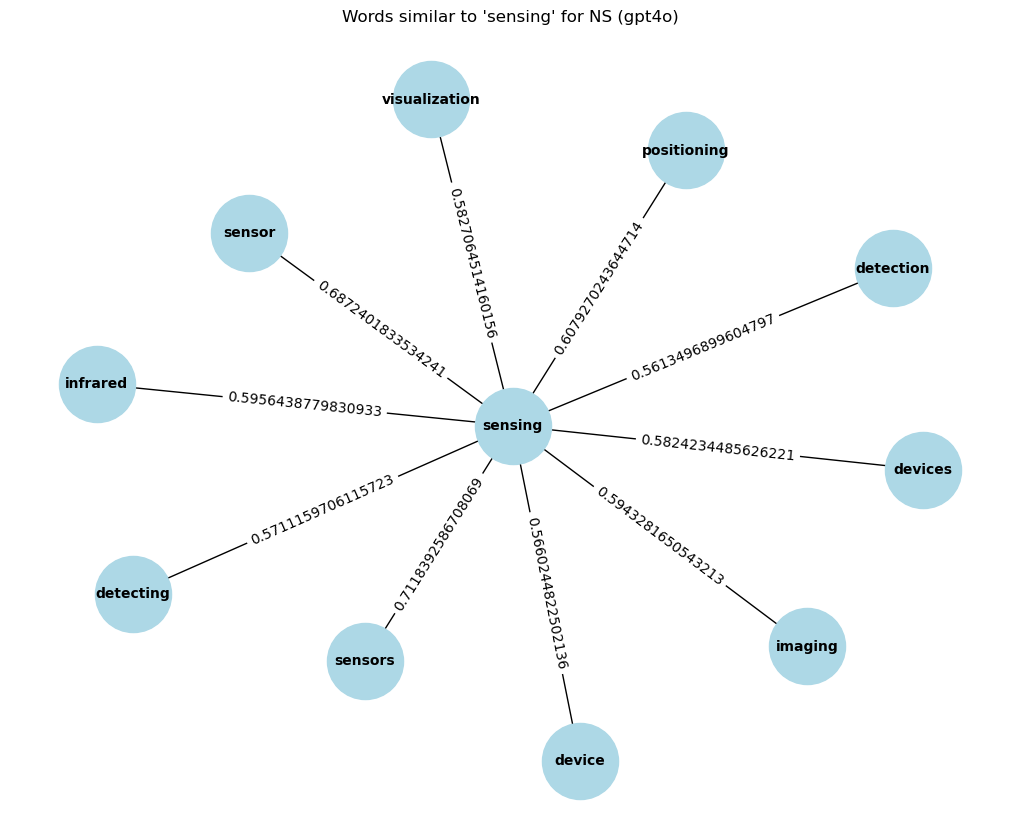

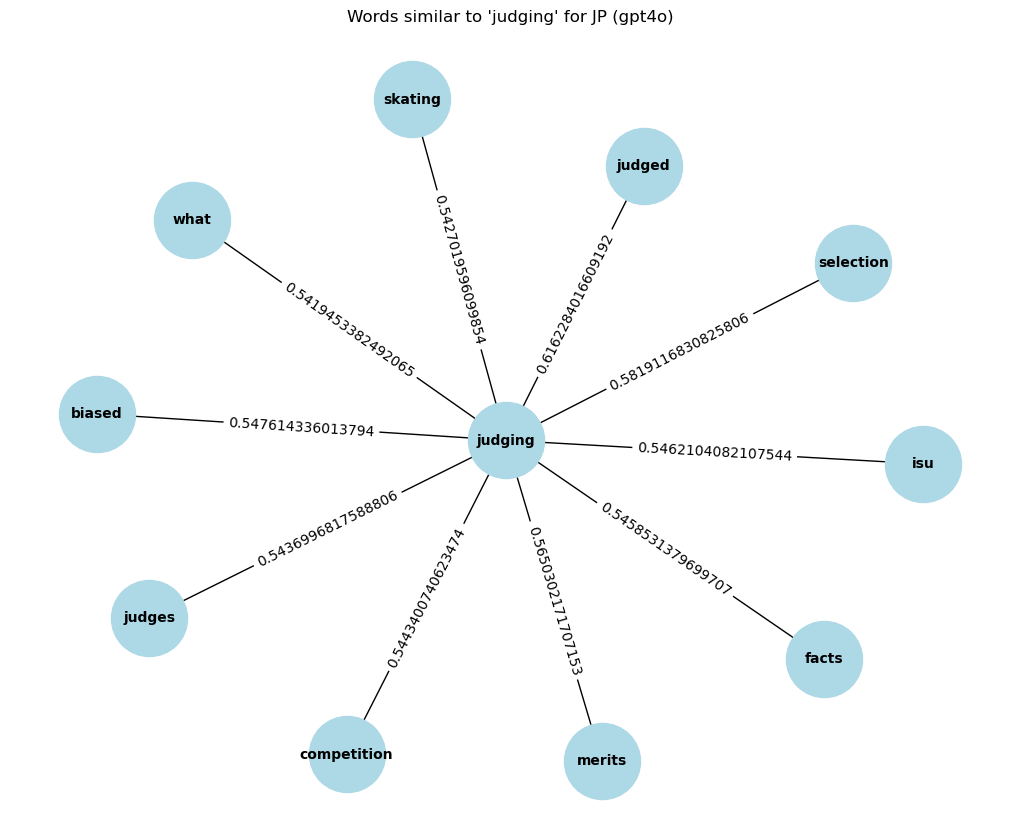

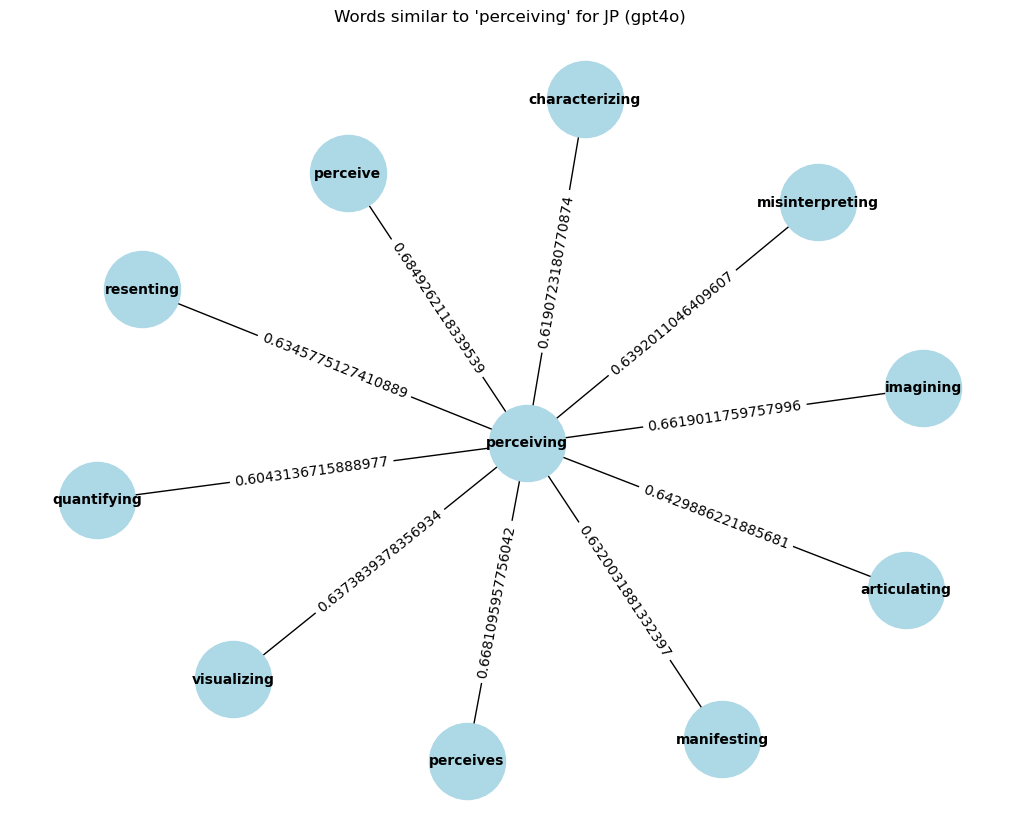


word_usage_comparison
Words more common in correct predictions:
{'speaker'}

Words more common in incorrect predictions:
{'in'}

Words common to both:
{'shows', 'and', 'indicating', 'ideas', 'concrete', 'exploring', 'preference', 'depth', 'for', 'theoretical', 'on', 'emphasizes', 'a', 'intuition', 'the', 'over', 'emotional', 'of', 'abstract'}


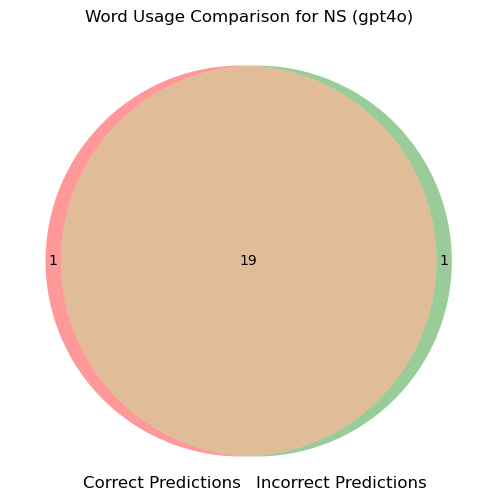

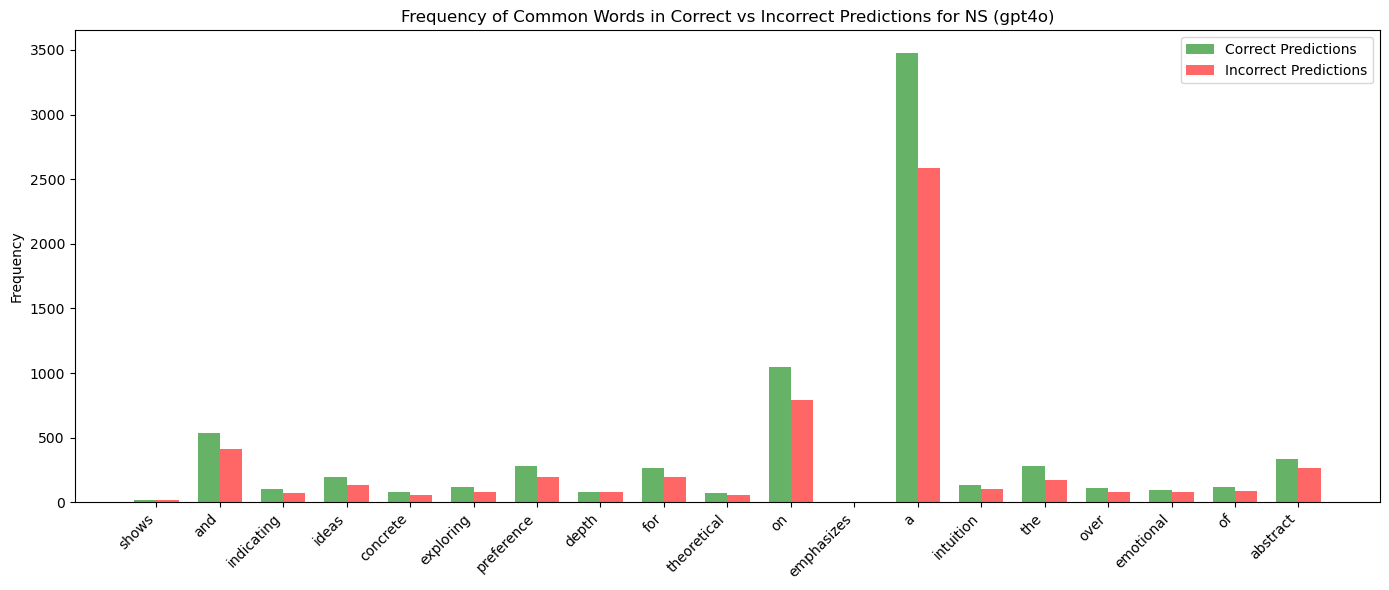

Words more common in correct predictions:
{'over', 'judging'}

Words more common in incorrect predictions:
{'rather', 'indicating'}

Words common to both:
{'speaker', 'approach', 'in', 'demonstrates', 'for', 'the', 'of', 'to', 'with', 'than', 'perceiving', 'a', 'shows', 'contemplative', 'characteristic', 'and', 'preference', 'flexibility'}


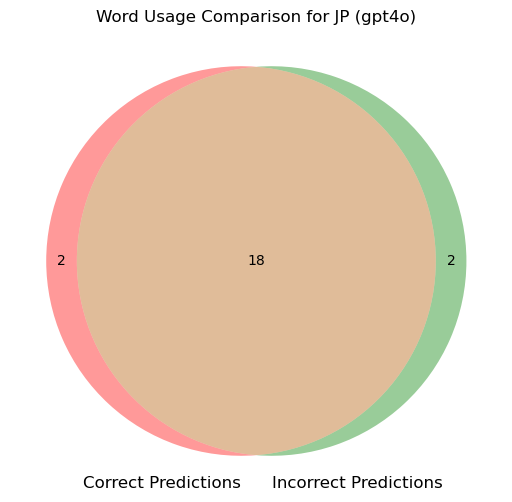

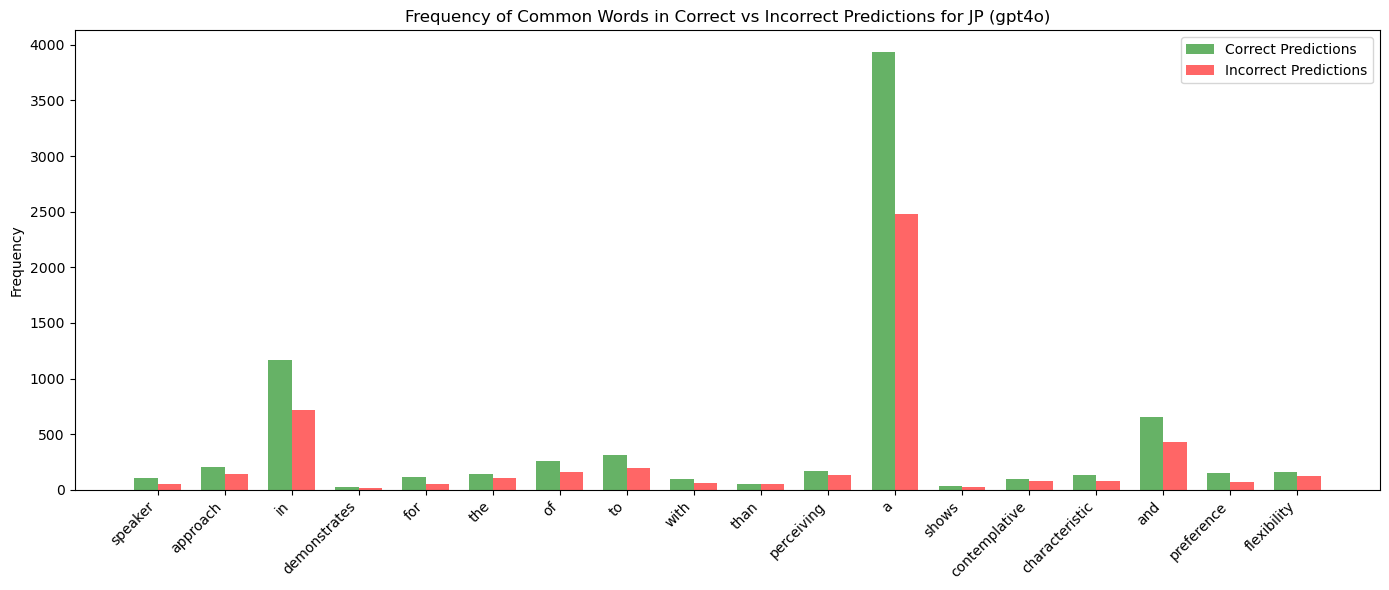

In [17]:
run(models = 'gpt4o',
    traits = ['NS', 'JP'])

In [ ]:
run(models = 'claude',
    traits = ['NS', 'JP'])